<div id="container" style="position:relative;">
<div style="float:left"><h1> Leveraging Data Science to Promote Transparency in Elections: </h1></div>
<div style="float:left"><h2> The case of Peru </h2></div> 
<div style="position:relative; float:right"><img style="height:60px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>   

### Notebook 3 of 4 : Decission Tree Analysis 
**by Giancarlo Marchesi**

## Introduction

In this notebook we will use a Decission Tree Regressor to predict the expected vote count for both Fujimori and Castillo per polling station at the national level. We will contrast it to the results of the regression analysis. We will work with the same clean data set used in that analysis.

### 1. Data loading

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [132]:
dfr=pd.read_csv('data/merged_reg.csv')

In [7]:
dfr.head(3)

,Geocode,State,Province,District,Poll_station,Ballot_summary_cond_2,Votes_2,Eligible_voters_2,Castillo_2,Fujimori_2,...,Galvez,Salaverry,Castillo_1,Alcantara,Acuna,Blank_1,Null_1,Contested_1,Elig_delta,Vote_delta
0,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,13,Counted,220.0,300,115.0,87.0,...,0.0,1.0,25.0,0.0,9.0,19.0,16.0,0.0,0,32.0
1,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,26,Counted,144.0,300,71.0,58.0,...,2.0,1.0,7.0,0.0,4.0,13.0,17.0,0.0,0,41.0
2,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,30,Counted,129.0,300,71.0,50.0,...,0.0,2.0,3.0,2.0,3.0,14.0,5.0,0.0,0,41.0


In [4]:
dfr.shape

(84452, 40)

### 2. Fujimori National Model

#### 2.1 Without Hyperparameter Optimization

We will first try a decision tree regressor model with a max depth of 3 and without K-fold validation (only train and test) to contrast it's results with an optimized model later on.  

In [133]:
## Separating the target variable, Fujimori's second round vote count
yf=dfr.iloc[:,9]

In [134]:
## The independent variables are the delta in turnout for the second round and the votes of individual candidates in the first round 
X=dfr.iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [135]:
Xcol=X.columns

In [136]:
# Train-Test-Split the data with a sample size of 30% for the test set
X_train, X_test, y_train, y_test = train_test_split(X, yf, test_size=0.30, random_state=1)

In [138]:
fujidt = DecisionTreeRegressor(max_depth=3)
fujidt.fit(X_train, y_train)

print(f"DT R^2 score on training set: {fujidt.score(X_train, y_train):0.3f}")
print(f"DT R^2 score on test set: {fujidt.score(X_test, y_test):0.3f}")

DT R^2 score on training set: 0.784
DT R^2 score on test set: 0.784


Without optimization, the R2 of the national model is much lower than the linear regresion model, 0.92. However, the test and train have basically the same score. Let's see which features where the most important.  

In [39]:
Xcol

Index(['Humala', 'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto',
       'Urresti', 'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez',
       'Galvez', 'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna',
       'Vote_delta'],
      dtype='object')

In [40]:
fujidt.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.02622839,
       0.        , 0.0371334 , 0.        , 0.        , 0.        ,
       0.23186734, 0.        , 0.59895282, 0.        , 0.        ,
       0.10581805, 0.        , 0.        , 0.        ])

In [139]:
## Let's see this better in a visualization. Let's create a dataframe
share_var=pd.DataFrame(data=fujidt.feature_importances_, columns=['share_var'])

In [140]:
Xcol=pd.DataFrame(data=Xcol, columns=['features'])

In [141]:
feat_impf=Xcol.merge(share_var, left_index=True, right_index=True)

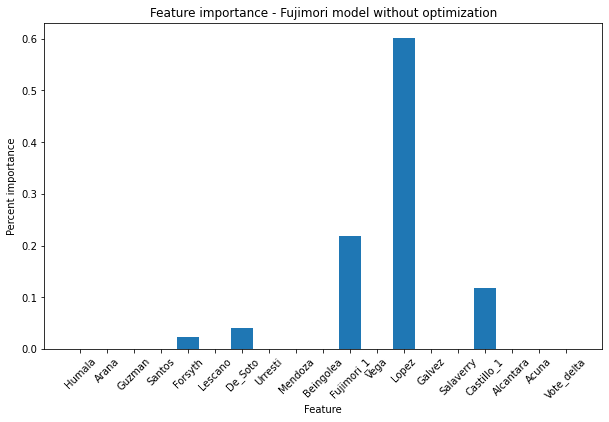

In [142]:
plt.figure(figsize=(10,6))
plt.bar(feat_impf['features'], feat_impf['share_var'])
plt.title('Feature importance - Fujimori model without optimization')
plt.ylabel('Percent importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

It seems that most variables are unnecessary. Only Lopez and DeSoto (who endorsed her), her own votes and Castillo's are relevant. In the case of Castillo, since this type of model does not show coefficients, we suppose that lower Castillo vote count is associated with higher for Fujimori.  

Now, let's try to optimize the hyperparameters for the model. We will use this smaller model with only 5 variables to save processing time, the 4 candidates and the turnout delta, as it was an important feature in the linear regression model. 

#### 2.2 With Hyperparameter Optimization  

In [146]:
## The independent variables are the delta in turnout for the second round and the votes of individual candidates in the first round 
X2=dfr.iloc[:,[23,27,29,32,39]]

In [147]:
#Obtaining the array of column names for future use
X2col=X2.columns

In [148]:
## taking a 20% sample for the test set
X2_remainder, X2_test, y2_remainder, y2_test = train_test_split(X2, yf, test_size = 0.2, random_state=1)

In the following version of the model, we will use a 5-fold validation while trying to optimize the max depth up to 15 nodes. 

In [149]:
## Optimizing for r2 with max depth
## Creating an empty list for R2 scores and providing a list of possible max depths

r2_crossval = []
max_d = range(2,16)

#Looping over the model with different depths while setting cross validation parameter at 5-fold
for m in max_d:
    DTmodel = DecisionTreeRegressor(max_depth=m)
    r2 = np.mean(cross_val_score(DTmodel, X2_remainder, y2_remainder, cv = 5)) 
    r2_crossval.append(r2)

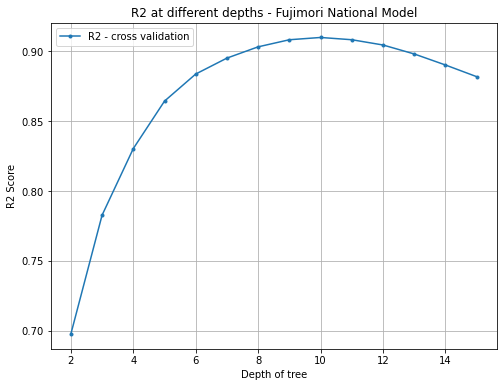

The best model has a max depth =  10


In [150]:
## Graphing the results
plt.figure(figsize=(8,6))
plt.plot(max_d, r2_crossval, label="R2 - cross validation", marker='.')
plt.legend()
plt.title('R2 at different depths - Fujimori National Model')
plt.xlabel('Depth of tree')
plt.ylabel('R2 Score')
plt.grid()
plt.show();

which_max = np.array(r2_crossval).argmax()

print("The best model has a max depth = ",max_d[which_max])

Now let's run a model with max depth 10 on the test set and score it. 

In [151]:
DTmodelopt = DecisionTreeRegressor(max_depth=10)
DTmodelopt.fit(X2_test, y2_test)

DecisionTreeRegressor(max_depth=10)

In [152]:
DTmodelopt.score(X2_test, y2_test)

0.9400041478131703

The R2 of the model 0.94, better than linear regression's 0.924. We can obtain a prediction array and add it to the dataframe. 

In [153]:
## predict on the X2 dataset
y2_predict = DTmodelopt.predict(X2)

In [154]:
## these predictions can be included into the dataframe as a column
y2_predict

array([100.61904762,  71.45762712,  63.05263158, ..., 124.1971831 ,
       103.51282051, 115.76229508])

In [155]:
## include these predictions into the dataset
dfr['tree_pred']=y2_predict

In [156]:
dfr.columns

Index(['Geocode', 'State', 'Province', 'District', 'Poll_station',
       'Ballot_summary_cond_2', 'Votes_2', 'Eligible_voters_2', 'Castillo_2',
       'Fujimori_2', 'Blank_2', 'Null_2', 'Contested_2', 'Region',
       'Ballot_summary_cond_1', 'Votes_1', 'Eligible_voters_1', 'Humala',
       'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto', 'Urresti',
       'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez', 'Galvez',
       'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna', 'Blank_1', 'Null_1',
       'Contested_1', 'Elig_delta', 'Vote_delta', 'tree_pred'],
      dtype='object')

In [157]:
## Taking a look at the feature importances
DTmodelopt.feature_importances_

array([0.08200409, 0.23429001, 0.5432615 , 0.13225521, 0.00818919])

In [158]:
X2col

Index(['De_Soto', 'Fujimori_1', 'Lopez', 'Castillo_1', 'Vote_delta'], dtype='object')

These are the feature importances for the last max_depth model (10) fit on the test set. The most important feature is the third one, Lopez votes, with the second one being Fujimori votes. Turnout delta is almost non relevant. Since the model has 10 nodes, a visual representation is impractical. Nevertheless, we can use these new predicted values to run the outlier analysis again and compare.  

### 3. Castillo National Model

We will run a similar model to the optimized version above using Castillo's second round vote as the target.  

### 3.1 With Hyperameter Optimization 

In [159]:
## Separating the target variable, Castillo's second round vote count
yc=dfr.iloc[:,8]

In [160]:
## The independent variables are the delta in turnout for the second round and the votes of individual candidates in the first round 
Xc=dfr.iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [161]:
Xccol=Xc.columns

In [162]:
## taking a 20% sample for the test set
Xc_remainder, Xc_test, yc_remainder, yc_test = train_test_split(Xc, yc, test_size = 0.2, random_state=1)

In [163]:
## Optimizing for r2 with max depth
## Creating an empty list for R2 scores and providing a list of possible max depths

r2_crossval_c = []
max_d = range(2,16)

#Looping over the model with different depths while setting cross validation parameter at 5-fold
for m in max_d:
    DTmodelc = DecisionTreeRegressor(max_depth=m)
    r2 = np.mean(cross_val_score(DTmodelc, Xc_remainder, yc_remainder, cv = 5)) 
    r2_crossval_c.append(r2)

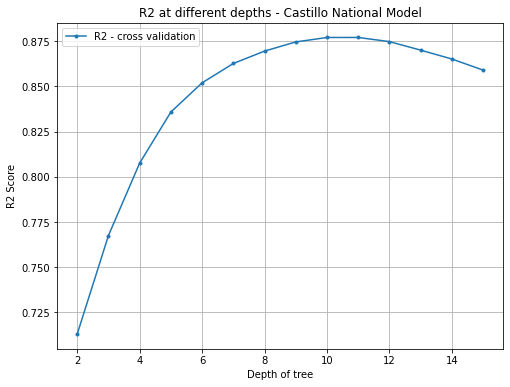

The best model has a max depth =  11


In [164]:
## Graphing the results
plt.figure(figsize=(8,6))
plt.plot(max_d, r2_crossval_c, label="R2 - cross validation", marker='.')
plt.legend()
plt.title('R2 at different depths - Castillo National Model')
plt.xlabel('Depth of tree')
plt.ylabel('R2 Score')
plt.grid()
plt.show();

which_max = np.array(r2_crossval_c).argmax()

print("The best model has a max depth = ",max_d[which_max])

In [165]:
## Now let's score the Castillo model on the test set
DTmodeloptc = DecisionTreeRegressor(max_depth=11)
DTmodeloptc.fit(Xc_test, yc_test)

DecisionTreeRegressor(max_depth=11)

In [166]:
DTmodeloptc.score(Xc_test, yc_test)

0.9321917780094217

This is an interersting improvement over R2 of the linear regresion model, 0.902.   

In [167]:
## predict on the X2 dataset
yc_predict = DTmodeloptc.predict(Xc)

In [168]:
## include these predictions into the dataset
dfr['tree_pred_cast']=yc_predict

In [169]:
dfr.columns

Index(['Geocode', 'State', 'Province', 'District', 'Poll_station',
       'Ballot_summary_cond_2', 'Votes_2', 'Eligible_voters_2', 'Castillo_2',
       'Fujimori_2', 'Blank_2', 'Null_2', 'Contested_2', 'Region',
       'Ballot_summary_cond_1', 'Votes_1', 'Eligible_voters_1', 'Humala',
       'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto', 'Urresti',
       'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez', 'Galvez',
       'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna', 'Blank_1', 'Null_1',
       'Contested_1', 'Elig_delta', 'Vote_delta', 'tree_pred',
       'tree_pred_cast'],
      dtype='object')

In [170]:
## Taking a look at the feature importances
DTmodeloptc.feature_importances_

array([1.17011379e-02, 1.06355788e-03, 3.97782768e-04, 3.04415944e-04,
       2.32048986e-03, 5.07699324e-02, 9.46837428e-03, 9.59545138e-03,
       3.86686850e-02, 7.89880369e-04, 6.08176461e-03, 1.62820560e-03,
       3.63552401e-03, 2.16589391e-03, 4.75317488e-03, 8.20768013e-01,
       7.07425875e-04, 2.79341561e-02, 7.24613415e-03])

In [171]:
Xccol

Index(['Humala', 'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto',
       'Urresti', 'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez',
       'Galvez', 'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna',
       'Vote_delta'],
      dtype='object')

For the most part, importances are low except for Castillo's, and to a lesser extend Mendoza's, something we also saw in the regression analysis. 

### 4. Predicted vs Official Data

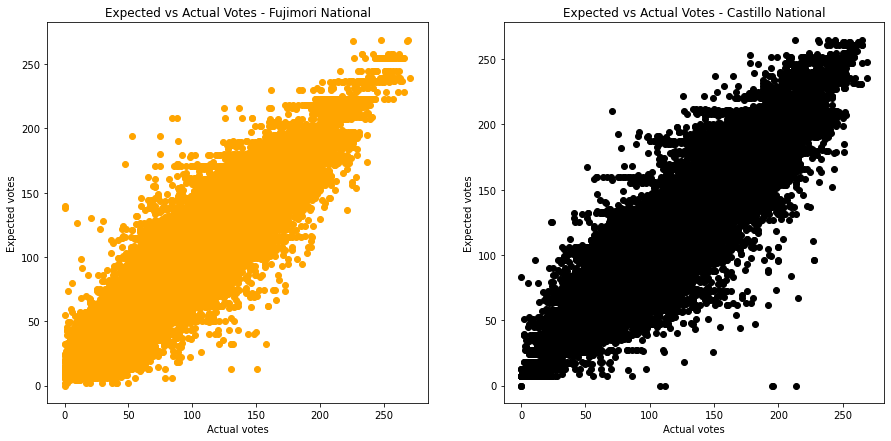

In [172]:
## Putting them side by side
plt.subplots(1,2, figsize=(15,7))

plt.subplot(1, 2, 1)
plt.scatter(dfr['Fujimori_2'], dfr['tree_pred'], color='orange')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
##plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Fujimori National')

plt.subplot(1, 2, 2)
plt.scatter(dfr['Castillo_2'], dfr['tree_pred_cast'], color='black')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
##plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Castillo National')

plt.show()

By and large, expected and actual votes match for both candidates along a straight line. We can see in the case of Fujimori some outliers in the top half, where she obtained less votes than expected. The same can be said about Castillo. 

### 5. Conclusion: 

The Decision Tree Regressor model has improved the R2 of both candidates at the national level when comparing with the linear regression models developed in Notebook 2. In a next iteration of this project, the predicted results can serve to contrast the results of the outlier analysis obtained with regression analysis.    

The DTR model has confirmed some of the findings of the linear regressor. In the case of Fujimori, the importance of the endorsement of Lopez de Aliaga and De Soto. In the case of Castillo, he was riding high on his own momentum and some support from progressive leftist Veronika Mendoza. She shows the second highest regression coefficient and the second feature importance for Castillo, after Castillo's first round performance.  